# This is a notebook for querying the Argo instance.
* You can run each cell individually by pressing "shift + enter".
* Please run the first few cells in order for the input widgets to appear.
* For more information, questions, bugs, please contact us on Slack:
    + https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2n95bd4rk-XMtZ9AVhVapwrFna1J5qmA.

#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token that you should receive via Blue-Cloud between the '' " in the cell below.

In [2]:
Token = ''

#### Importing the required packages.

In [3]:
import requests
import json
import xarray as xr
import datetime
from ipywidgets import interact, widgets, interactive
from IPython.display import Javascript, display
import pandas as pd
import os

#### This retrieves the available parameters from the footprint.

In [4]:
if not os.path.exists('./Footprint'):
    os.makedirs('Footprint')

responseinfo = requests.get("https://beacon-argo.maris.nl/api/datasets/footprint", headers = {'Authorization' : f'Bearer {Token}'}) 
open('./Footprint/Footprint_Argo.json', 'wb').write(responseinfo.content)
with open('./Footprint/Footprint_Argo.json', 'r') as f:
    data = json.load(f)

pd.set_option('display.max_rows', 20)
attributes = pd.DataFrame.from_dict(data['unique_column_attributes'], orient='index')
attributes.reset_index(level=0, inplace=True)
attributes = attributes.sort_values('index', ascending=True, key=lambda col: col.str.lower())
params = attributes['index'].to_numpy()

#### In the widgets below, you should select your preferred filters and press "Execute all cells" to run the whole notebook. Note that in this example you have the option to select two parameters.

In [5]:
def f(parameter, parameter2, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp):
    return parameter, parameter2, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp

w = interactive(f, parameter = params, parameter2 = params, minlon = (-180, 180, 1), maxlon = (-180, 180, 1), minlat = (-90, 90, 1), maxlat = (-90, 90, 1), mindepth = widgets.IntSlider(min = 0, max = 5000, value = 0), maxdepth = widgets.IntSlider(min = 0, max = 5000, value = 10), mintemp = widgets.DatePicker(description='Start date:', value = datetime.date(2010, 1, 1)), maxtemp = widgets.DatePicker(description='End date:', value = datetime.date(2024, 1, 1)))

display(w)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description = "Execute all cells")
button.on_click(run_all)
display(button)

interactive(children=(Dropdown(description='parameter', options=('BBP470', 'BBP470_ADJUSTED', 'BBP470_ADJUSTED…

Button(description='Execute all cells', style=ButtonStyle())

#### Storing the chosen filters.

In [6]:
parameter = w.kwargs['parameter']
parameter2 = w.kwargs['parameter2']
mintemp = w.kwargs['mintemp']
maxtemp = w.kwargs['maxtemp']
minlon = w.kwargs['minlon']
maxlon = w.kwargs['maxlon']
minlat = w.kwargs['minlat']
maxlat = w.kwargs['maxlat']
mindepth = w.kwargs['mindepth']
maxdepth = w.kwargs['maxdepth'] 

#### The fields below are fixed for the Argo instance.

In [7]:
unit = attributes.loc[attributes['index'] == parameter]['units'].iloc[0]
unit2 = attributes.loc[attributes['index'] == parameter2]['units'].iloc[0]
dateref = datetime.date(1950, 1, 1) #Days since 1950
mintemporal = (mintemp - dateref).days #Days since 1950
maxtemporal = (maxtemp - dateref).days #Days since 1950
regionname = f'[{minlat},{minlon}],[{maxlat},{maxlon}]' 

#### Query body based on your input fields, you can add other "query_parameters" and "filters" to suit your needs. 
* For more query examples, you can take a look at https://maris-development.github.io/beacon/available-nodes/blue-cloud-2026/argo-floats.html.  
* In this example, we include two parameters, based on the user's widget input above. Note that the second parameter is defined optional, meaning that if there is a temperature measurement, but no salinity measurement, the temperature data will still be provided. 

In [8]:
def query(parameter, parameter2, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter,
                "optional": False
            },
            {
                "column_name": parameter2,
                "alias": parameter2,
                "optional": True
            },
            {
                "column_name": "JULD",
                "alias": "TIME"
            },
            {
                "column_name": "PRES",
                "alias": "DEPTH"
            },
            {
                "column_name": "LONGITUDE",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "LATITUDE",
                "alias": "LATITUDE"
            }
        ],
        "filters": [
            {
              "for_query_parameter": "TIME",
              "min": mintemporal,
              "max": maxtemporal
            },
            {
              "for_query_parameter": "DEPTH",
              "min": mindepth,
              "max": maxdepth
            },
            {
              "for_query_parameter": "LONGITUDE",
              "min": minlon,
              "max": maxlon
            },
            {
              "for_query_parameter": "LATITUDE",
              "min": minlat,
              "max": maxlat
            }
        ],
        "output": {
            "format": "netcdf"
        }}
    return body

query = query(parameter, parameter2, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat)

#### This is the post request that is sent to Beacon with the above specified body.

In [9]:
response = requests.post("https://beacon-argo.maris.nl/api/query", json.dumps(query), headers = {
    'Authorization' : f'Bearer {Token}',
    'Content-type': 'application/json'
})

if response.status_code == 204:
    print('No data has been found for your query, please update your input fields above and run the notebook again.')
elif response.status_code != 200:
    print(response.text)

#### This will create a Netcdf file in your directory with the name based on your filters, the output is shown here in a dataframe.

In [10]:
if not os.path.exists('./DataOutput'):
    os.makedirs('DataOutput')

open(f'./DataOutput/Argo_{parameter}_{parameter2}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc', 'wb').write(response.content)
df = xr.open_dataset(f'./DataOutput/Argo_{parameter}_{parameter2}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc').to_dataframe()
df

,TEMP,PSAL,TIME,DEPTH,LONGITUDE,LATITUDE,dataset_id
INSTANCE,,,,,,,
0,25.209000,37.011002,22053.188889,1.0,-29.160,19.053,2260390
1,19.149000,35.558998,23639.036111,0.0,-22.251,43.145,2056842
2,19.148001,35.560001,23639.036111,1.0,-22.251,43.145,2056842
3,19.149000,35.558998,23639.036111,2.0,-22.251,43.145,2056842
4,19.152000,35.558998,23639.036111,3.0,-22.251,43.145,2056842
...,...,...,...,...,...,...,...
2188616,19.559000,35.948002,23663.860417,1.0,-27.987,38.880,2313595
2188617,19.558001,35.951000,23663.860417,2.0,-27.987,38.880,2313595
2188618,19.559000,35.951000,23663.860417,3.0,-27.987,38.880,2313595


#### Here, we do the following transformations of the dataframe.
* We sort the values on time.
* We convert the time (days since 1950) to a standard datetime format and set this as the index.
* We create a second new column and include here the day in which the measurement occurred.
* We identify the dataset_ids (indicating a unique Argo float cycle) where (in this example) the parameters temperature and salinity exceed preferred values.
* We exclude measurements belonging to those specific dataset_ids and create a filtered dataframe.

In [11]:
df.sort_values(by = ['TIME'], inplace = True)
date = []
df['Datetime'] = ""
for i in range(len(df['TIME'])):
    date.append(datetime.datetime(1950, 1, 1) + datetime.timedelta(days=df['TIME'].iloc[i]))
df['Datetime'] = date
df.set_index('Datetime', inplace = True)
df['day'] = df.index.round(freq = 'D')
datasetid_outliers = df.loc[(df['TEMP'] > 40) | (df['TEMP'] < 0) | (df['PSAL'] > 40) | (df['PSAL'] < 30)]['dataset_id'].unique()
dffilter = df[~df['dataset_id'].isin(datasetid_outliers)]
dffilter

,TEMP,PSAL,TIME,DEPTH,LONGITUDE,LATITUDE,dataset_id,day
Datetime,,,,,,,,
2010-01-01 02:30:48.672000,18.280001,36.407001,21915.104730,5.0,-19.170,35.800,2223208,2010-01-01
2010-01-01 04:01:02.000002,10.569000,35.424999,21915.167384,4.3,-17.245,56.910,1971406,2010-01-01
2010-01-01 04:25:00.000000,13.331000,35.798000,21915.184028,1.0,-19.097,43.857,2246361,2010-01-01
2010-01-01 04:38:00.000000,24.414000,37.081001,21915.193056,0.0,-27.133,21.493,2261541,2010-01-01
2010-01-01 04:38:00.000000,24.414000,37.081001,21915.193056,0.0,-27.133,21.493,2261739,2010-01-01
...,...,...,...,...,...,...,...,...
2014-12-31 23:11:00.000000,13.020000,35.673000,23740.965972,5.0,-14.984,46.378,2311665,2015-01-01
2014-12-31 23:11:00.000000,13.019000,35.672001,23740.965972,1.0,-14.984,46.378,2311665,2015-01-01
2014-12-31 23:11:00.000000,13.019000,35.673000,23740.965972,0.0,-14.984,46.378,2311665,2015-01-01


#### Plotting of results for parameter 1, if there are a lot of measurements, it may take quite some time (+-5 min).

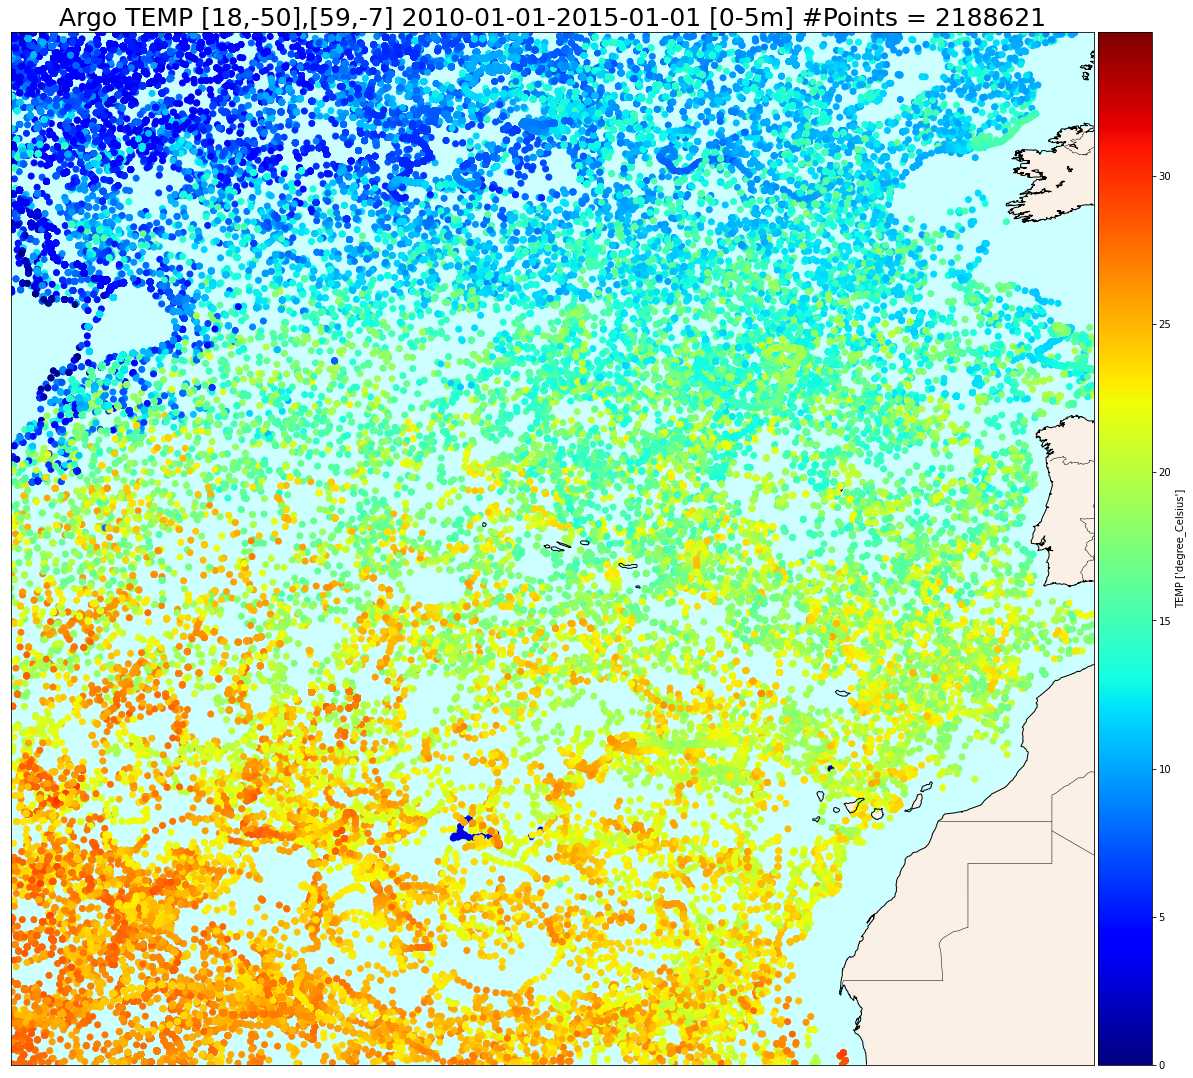

In [12]:
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(1, figsize = (29, 19))

m = Basemap(projection = 'cyl', llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat, resolution = 'i') 
m.drawlsmask(land_color = 'Linen', ocean_color = '#CCFFFF'); # can use HTML names or codes for colors
m.drawcoastlines()
m.drawcountries()

sc = m.scatter(dffilter['LONGITUDE'], dffilter['LATITUDE'], latlon = True, c = dffilter[parameter], cmap = plt.cm.jet)

plt.title(f'Argo {parameter} {regionname} {mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")} [{mindepth}-{maxdepth}m] #Points = {len(df)}', fontsize = 25)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(sc, cax = cax, label = f'{parameter} {unit}');

#### Plotting of results of parameter 2, if there are a lot of measurements, it may take quite some time (+-5 min).

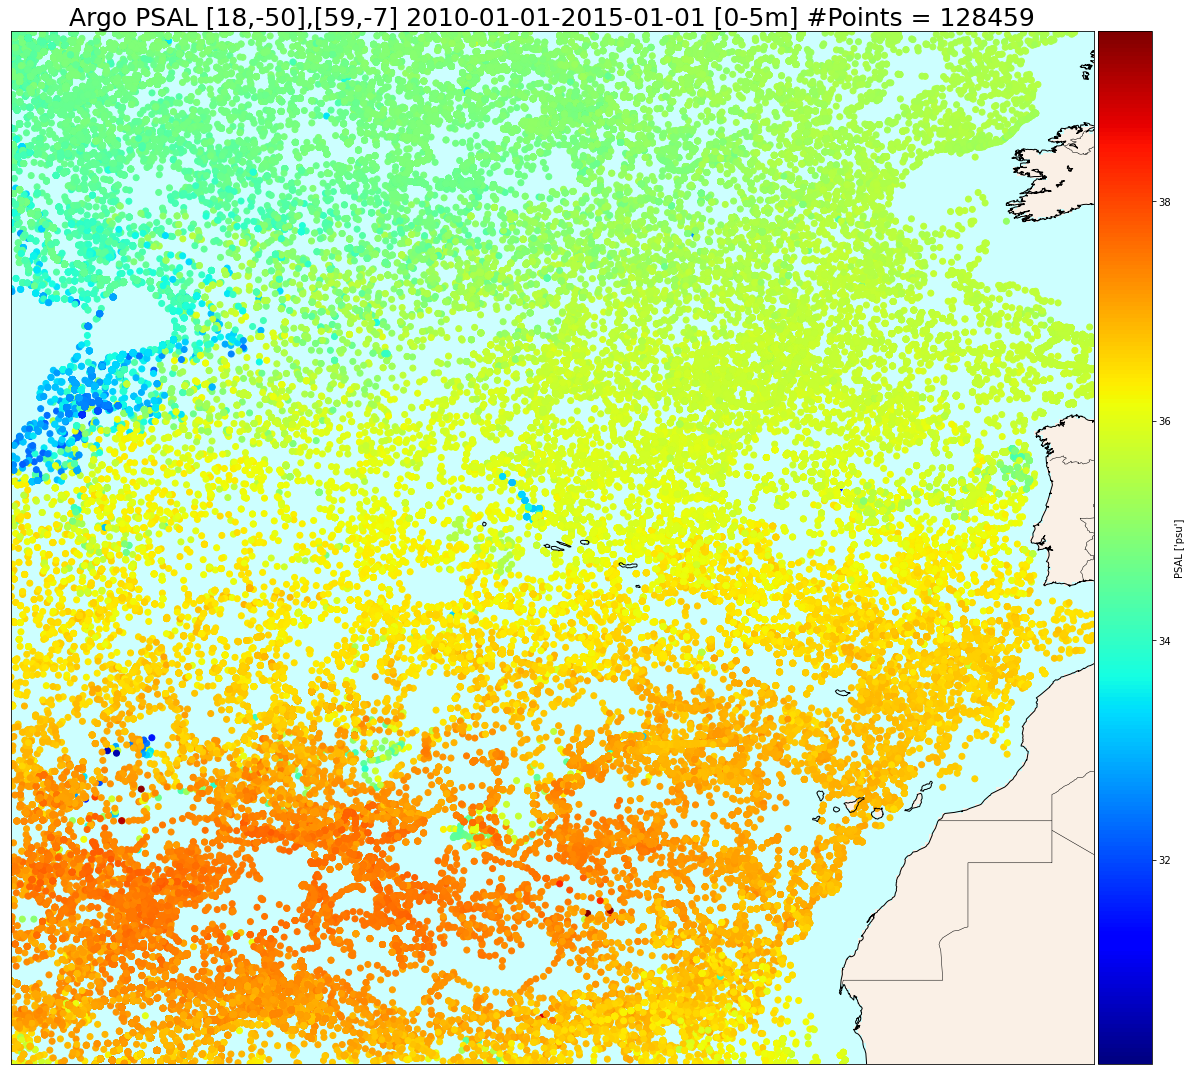

In [13]:
fig = plt.figure(1, figsize = (29, 19))

m = Basemap(projection = 'cyl', llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat, resolution = 'i') 
m.drawlsmask(land_color = 'Linen', ocean_color = '#CCFFFF'); # can use HTML names or codes for colors
m.drawcoastlines()
m.drawcountries()

sc = m.scatter(dffilter['LONGITUDE'], dffilter['LATITUDE'], latlon = True, c = dffilter[parameter2], cmap = plt.cm.jet)

plt.title(f'Argo {parameter2} {regionname} {mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")} [{mindepth}-{maxdepth}m] #Points = {len(dffilter)}', fontsize = 25)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(sc, cax = cax, label = f'{parameter2} {unit2}');

#### We determine the average daily value of both parameters.

In [14]:
average1 = dffilter.groupby(['day'])[parameter].mean() 
average2 = dffilter.groupby(['day'])[parameter2].mean() 

#### We create a plot, indicating the average daily values for both parameters.

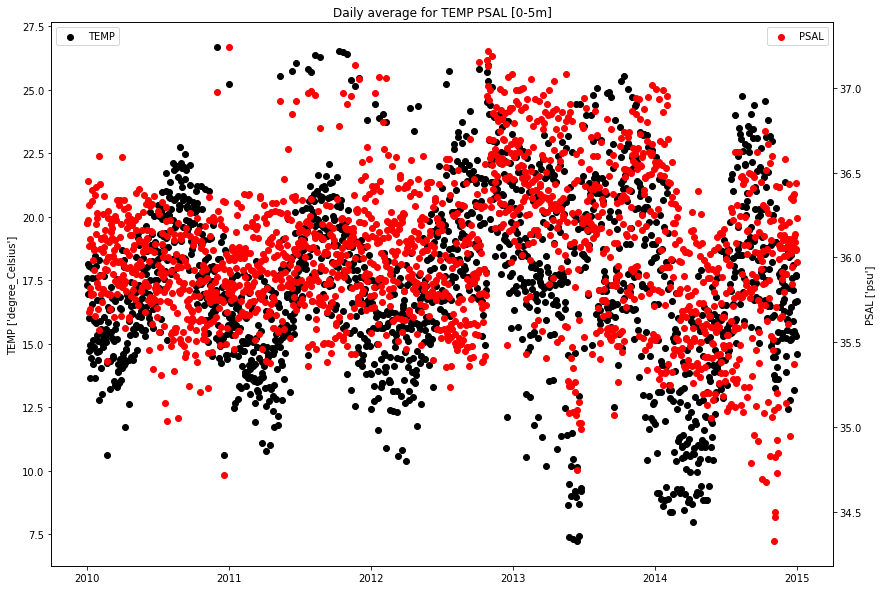

In [15]:
import matplotlib.pyplot as plt
fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))
ax1 = plt.subplot()
ax1.scatter(dffilter['day'].unique(), average1, c = 'k', marker = 'o', label = f'{parameter}')
ax1.set_title(f'Daily average for {parameter} {parameter2} [{mindepth}-{maxdepth}m]')
ax1.set_ylabel(f'{parameter} {unit}')
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.scatter(dffilter['day'].unique(), average2, c = 'r', marker = 'o', label = f'{parameter2}')
ax2.set_ylabel(f'{parameter2} {unit2}')
ax2.legend(loc = 'upper right');
